In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [2]:
# Tamaño de imagen para el modelo pre-entrenado
IMG_SIZE = 224

In [3]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(data_dir):
    images = []  # Lista para almacenar imágenes
    labels = []  # Lista para almacenar etiquetas
    filenames = []  # Lista para almacenar los nombres de archivos
    label_map = {label: idx for idx, label in enumerate(os.listdir(data_dir))}  # Mapa de etiquetas a índices
    
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        print (class_dir)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)  # Cargar la imagen
            if img is not None:  # Verificar si la imagen se ha cargado correctamente
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Redimensionar la imagen
                img = img / 255.0  # Normalizar la imagen
                images.append(img)
                labels.append(label_map[label])
                filenames.append((img_file, img_path))
            else:
                print(f"Advertencia: No se pudo cargar la imagen {img_path}")
            
    return np.array(images), np.array(labels), label_map, filenames  # Devolver las imágenes, etiquetas, mapa de etiquetas y nombres de archivos

In [4]:
# Función para detección y reconocimiento de objetos
def detect_and_recognize(image_path, model, label_map, filenames, data_dir):
    img = cv2.imread(image_path)  # Cargar la imagen
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Redimensionar la imagen
    img = img / 255.0  # Normalizar la imagen
    img = np.expand_dims(img, axis=0)  # Añadir dimensión para batch

    predictions = model.predict(img)  # Hacer predicción
    predicted_class = np.argmax(predictions)  # Obtener clase predicha
    
    # Verificar si la imagen entregada coincide con alguna del dataset
    class_name = [label for label, idx in label_map.items() if idx == predicted_class][0]
    class_dir = os.path.join(data_dir, class_name)
    for img_file, img_path in filenames:
        if img_file.startswith(class_name):  # Verificar si la imagen pertenece a la clase predicha
            dataset_img = cv2.imread(img_path)
            dataset_img = cv2.resize(dataset_img, (IMG_SIZE, IMG_SIZE))
            dataset_img = dataset_img / 255.0

            if np.allclose(img, np.expand_dims(dataset_img, axis=0), atol=1e-2):
                return f"La imagen fue encontrada y el nombre es '{img_file}'", img_path

    return "La imagen no existe en el dataset", None

In [5]:
# Ruta del directorio de datos (ajusta esta ruta según tu sistema)
data_dir = 'lfw'  # Ajusta según sea necesario

# Cargar y preprocesar las imágenes
images, labels, label_map, filenames = load_and_preprocess_images(data_dir)


lfw\Alvaro_Uribe
lfw\Brad_Pitt
lfw\Gwyneth_Paltrow
lfw\Hugo_Chavez
lfw\Infanta_Cristina
lfw\John_Paul_II
lfw\Lucio_Gutierrez
lfw\Luiz_Inacio_Lula_da_Silva
lfw\Muhammad_Ali
lfw\Oscar_De_La_Hoya
lfw\Prince_Felipe
lfw\Wilfrido_Almache


In [6]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Cargar el modelo pre-entrenado MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Añadir capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_map), activation='softmax')(x)

# Definir el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base para no entrenarlas
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el rendimiento del modelo en el conjunto de datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')



Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.7619 - val_loss: 0.9587
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.7381 - val_loss: 1.0009
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.7619 - val_loss: 0.9489
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.7619 - val_loss: 0.9253
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.7619 - val_loss: 0.9351
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.7619 - val_loss: 0.9535
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.7619 - val_loss: 0.9594
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7619 - val_loss: 0.9635
Epoch 9/10
6/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
La imagen fue encontrada y el nombre es 'Oscar_De_La_Hoya_0003.jpg'


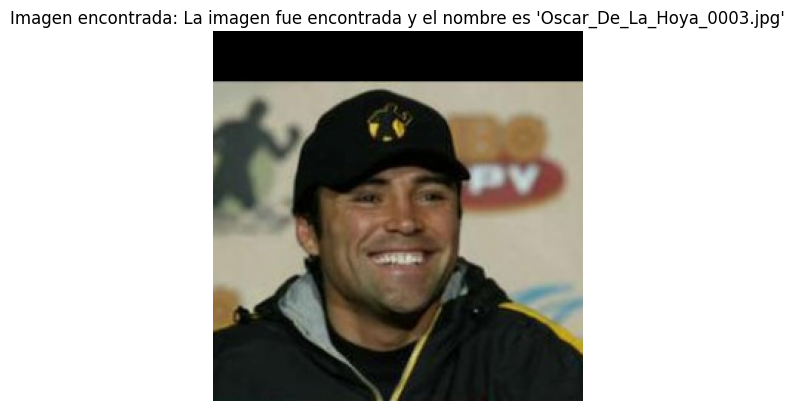

In [12]:
# Ejemplo de uso de la función de detección y reconocimiento
image_path = 'hoya.jpg'  # Ajusta según sea necesario
detected_label, detected_img_path = detect_and_recognize(image_path, model, label_map, filenames, data_dir)
print(detected_label)

# Mostrar la imagen si fue encontrada
if detected_img_path:
    img = cv2.imread(detected_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'Imagen encontrada: {detected_label}')
    plt.axis('off')
    plt.show()
else:
    print("La imagen no fue encontrada en el dataset.")